In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *






def get_dfs_by_model_template(process_gen_modes, recalculate_everything=False):
    dfs_by_model=None
    processGens=None
    df_files={}
    found_all_files=recalculate_everything
    for process_gen_mode in process_gen_modes:
        root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = get_process_gen_params(process_gen_mode)
        for model in models:        
            for task_name in task_names:
                for num_beams in num_beams_list:
                    df_file=get_df_file(root_folder=root_folder, num_beams=num_beams, model=model, task_name=task_name, suite_name=suite_name)

                    df_key= model + "_template"  if "template" in process_gen_mode else model
                    df_files[df_key]=df_file
                    print(f"model: {df_key}, df_file: {df_file}")

    found_all_files=True
    for df_file in df_files.values():
        if not os.path.isfile(df_file):
            print(f"Could not find file {df_file}")
            found_all_files=False
    
    if recalculate_everything or not found_all_files:
        processGens=ProcessGens()
        print("Recalculate everything!!!!!")
        processGens.init_with_mode(process_gen_modes)
        root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()

        examples_df, completions_df=get_dfs(processGens)
        dfs_by_model={}
        # for model_name in examples_df['model'].unique():
        #     filtered_df = examples_df[examples_df["model"]==model_name]
        #     dfs_by_model[model_name]=filtered_df

        for model_name in examples_df['model'].unique():

            filtered_df = examples_df[examples_df["model"]==model_name]

            is_template=filtered_df['suite'].str.contains("template")
            template_df = filtered_df[is_template]
            no_template_df = filtered_df[~is_template]

            dfs_by_model[model_name]=no_template_df
            dfs_by_model[model_name+"_template"]=template_df

            
        print(f"Keys: {dfs_by_model.keys()}")
        print(f"DF keys: {df_files.keys()}")
        for model_name, filtered_df in dfs_by_model.items():
            if model_name in df_files.keys():
                df_file = df_files[model_name]
                filtered_df.to_pickle(df_file)



    else:
        dfs_by_model={}
        for model, df_file in df_files.items():
            dfs_by_model[model] = pd.read_pickle(df_file)


    return dfs_by_model, processGens, (root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)


processGens=ProcessGens()

#wmt modes

process_gen_modes=["olmo_template", "llama_template", "wmt_samples0", "wmt_samples2_1", "wmt_samples2_2"]
# process_gen_modes=["olmo_template"]


dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model_template(process_gen_modes)
examples_df = pd.concat(list(dfs_by_model.values()))





/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


mode is wmttask_names is ['wmt_14_language_pair_de_en_']
model: allenai_OLMo_2_1124_13B_Instruct_template, df_file: snellius_copies/helm_output/sample_100_eval_500_first_inst_0_template_true/wmt_14_language_pair_de_en_/allenai_OLMo_2_1124_13B_Instruct/1_beams/runs/sample_100_eval_500_first_inst_0_template_true/example_df.pkl
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
model: meta_llama_Llama_3.1_8B_Instruct_template, df_file: snellius_copies/helm_output/llama_template/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/llama_template/example_df.pkl
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
model: meta_llama_Llama_3.1_8B_Instruct, df_file: snellius_copies/helm_output/sample_100_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_100_eval_1000/example_df.pkl
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
model: allenai_OLMo_2_1124_7B_Instruct, df_file: snellius_copies/helm_output/sample_100

In [2]:
print(dfs_by_model.keys())

dict_keys(['allenai_OLMo_2_1124_13B_Instruct_template', 'meta_llama_Llama_3.1_8B_Instruct_template', 'meta_llama_Llama_3.1_8B_Instruct', 'allenai_OLMo_2_1124_7B_Instruct', 'allenai_OLMo_2_1124_13B_Instruct'])


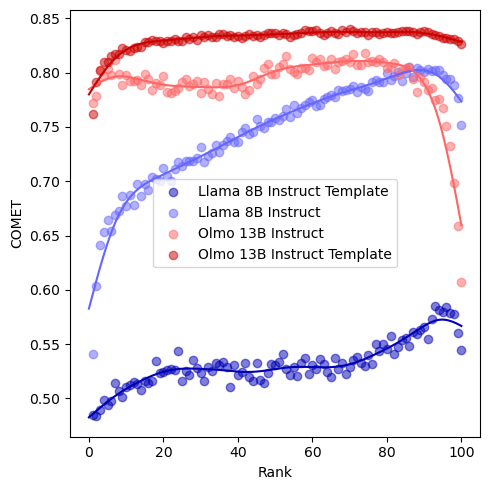

In [9]:
def make_kwargs(model_name):
    return {"df": dfs_by_model[model_name], "compare_metric":compare_metric, "label":get_model_details(model_name)["name"]}


models_array=[[  "meta_llama_Llama_3.1_8B_Instruct_template","meta_llama_Llama_3.1_8B_Instruct",   "allenai_OLMo_2_1124_13B_Instruct", "allenai_OLMo_2_1124_13B_Instruct_template"]]

kwargs_array=[ [make_kwargs(model) for model in models_vect]   for models_vect in models_array]

create_plots(kwargs_array=kwargs_array, graph_func=plot_gam, compare_metric=compare_metric, figsize=(5,5))

In [4]:
print(compare_metric)

example_comet
